<a href="https://colab.research.google.com/github/zek12/TensorFlow_notebooks/blob/master/classification_with_TensorFlow_on_MNIST_and_Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Classification with MNIST dataset

In this tutorial, we are going to use the dataset MNIST, from Keras. This dataset is composed of 70,000 pictures of 28x28 pixels, in grayscale (each pixel taking values between 0-255), of digits (between 0 and 9) written by hand. The dataset is split into a training set (composed of 60,000 samples) and a test set (composed of 10,000 samples).

In [63]:
import tensorflow as tf
import numpy as np

In [64]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

We can print the 8th image of the training set:

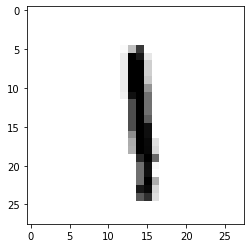

In [65]:
import matplotlib.pyplot as plt
plt.imshow(x_train[8], cmap = plt.cm.binary)

... and its corresponding label:

In [66]:
print(y_train[8])

1


The training set is formed by 60,000 pictures of 28x28 pixels:

In [67]:
print(x_train.ndim)
print(x_train.shape)
print(x_train.dtype)

3
(60000, 28, 28)
uint8


The test set is formed by 10,000 pictures of 28x28 pixels:

In [68]:
print(x_test.ndim)
print(x_test.shape)
print(x_test.dtype)

3
(10000, 28, 28)
uint8


We can slice our data, for example take the first 100 pictures:

In [69]:
my_slice = x_train[1:100:, :]
print(my_slice.shape)

(99, 28, 28)


Another way of doing the same:

In [70]:
my_slice = x_train[1:100, 0:28, 0:28]
print(my_slice.shape)

(99, 28, 28)


If we want to select the 14x14 pixels in the bottom-right corner of all pictures:

In [71]:
my_slice = x_train[:, 14:, 14:]
print(my_slice.shape)

(60000, 14, 14)


And if we want to select the 14x14 pixels in the centre of all pictures:

In [72]:
my_slice = x_train[:, 7:-7, 7:-7]
print(my_slice.shape)

(60000, 14, 14)


## 1. Preprocessing of input data

Each image in our input data consists of 28x28 pixels, each taking values between [0-255]. It's convenient to scale the pixels in a range [0-1], aka **normalization**, because this helps the training process to converge. Furthermore, in a neural network, we don't use values that are mich higher than the weights in the network, or data with heterogenous values between themselves.

In [73]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

Another useful transformation is **re-shaping** of data, i.e. instead of having a vector of matrices (each of 28x28 pixels), we can have a vector of vectors of length 28x28. This is because this is the format that a neural network accepts as input.

In [74]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [75]:
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

In [76]:
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


Finally, we can perform **one-hot encoding** on the labels (`y_train` and `y_test`).

In [77]:
from tensorflow.keras.utils import to_categorical

In [78]:
print(y_train[0])
print(y_test[0])

5
7


In [79]:
print(y_train.shape)
print(y_test.shape)

(60000,)
(10000,)


In [80]:
y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

In [81]:
print(y_train[0])
print(y_test[0])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [82]:
print(y_train.shape)
print(y_test.shape)

(60000, 10)
(10000, 10)


We now have the data in the format that we need in order to train our neural network.

## 2. Modelling

In our example, we will use class `Sequential`, which defines our model as a sequence of layers. Each layer will distill the input data to obtain the desired output.

Keras offers an API to define more complex models; more information in https://keras.io/guides/functional_api/.

In [83]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [84]:
model = Sequential()
model.add(Dense(10, activation = 'sigmoid', input_shape = (784,)))
model.add(Dense(10, activation = 'softmax'))

Here, we defined our model as a neural network with 2 layers (1 input and 1 output layer) with 10 neurons each, densely connected.

In [85]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 10)                7850      
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
_________________________________________________________________


We can see that the first layer has a total of 7850 parameters: these correspond to 784 input pixels * 10 input neurons = 7840 + 1 input bias in each neuron = **7850**.

The second layer has 110 parameters, which correspond to 10 outputs from first layer * 10 neurons in the second layer + 10 input biases in each neuron = **110**.

The sum of 7850 + 110 = **7960**.

We could also define initialization values to the weights of the nodes. This can be specified as an argument in `Dense()` function. More information in https://keras.io/api/layers/initializers/#usage-of-initializers.

## 3. Configure the training process

Before we can start training our model, we need to configure the training process with the `compile()` method.

In particular, we need to specify the following arguments:
- **loss**: this is the loss function, which will evaluate the degree of error between actual and predicted labels. For each observation, a prediction is made, then this loss function is calculated by comparing actual vs predicted values, and then the weights and biases are updated in a way that tries to minimize the loss function for the next observation.
- **optimizer**: this is how the model is updated based on the data it sees and its loss function. In this example, we will use `stochastic gradient descent` (sgd). Between observations, and after the loss function is calculated, this optimizer guides how the weights and biases will be updated.
- **metrics**: this is the metric to monitor the training and testing process. In this example, we will use `accuracy`. These will be the metrics that will appear in between epochs. These metrics do not guide the training process, and they are just for reporting to the user.

In [86]:
model.compile(loss = "categorical_crossentropy",
              optimizer = "sgd",
              metrics = ['accuracy'])

## 4. Train the model

In [87]:
model.fit(x_train, y_train, epochs = 5)

Epoch 1/5
1875/1875 [==============================] - 3s 1ms/step - loss: 1.8758 - accuracy: 0.5285
Epoch 2/5
1875/1875 [==============================] - 2s 1ms/step - loss: 1.2868 - accuracy: 0.7438
Epoch 3/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.9516 - accuracy: 0.8067
Epoch 4/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.7675 - accuracy: 0.8387
Epoch 5/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6574 - accuracy: 0.8570


This trains the model in 5 iterations (epochs). If argument ```batch_size``` is not specified in model.fit(), the default will be 32 samples. This means that the model will take 32 observations from the Training set, predict values, calculate loss function, apply optimizer to minimize the loss function and update the weights and biases before taking the next batch of 32 samples.

## 5. Model assessment

We can now evaluate the model's performance using the ```evaluate()``` function. This function returns 2 values.

In [88]:
test_loss, test_acc = model.evaluate(x_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.5964 - accuracy: 0.8723


In [89]:
print('Test accuracy:', test_acc)

Test accuracy: 0.8723000288009644


This accuracy is telling us that the model is correctly labelling ~87% of samples that were never visited (Test set).

**Confusion Matrix:**

In [90]:
# Look at confusion matrix 
#Note, this code is taken straight from the SKLEARN website, an nice way of viewing confusion matrix.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Observed')
    plt.xlabel('Predicted')

313/313 [==============================] - 0s 984us/step


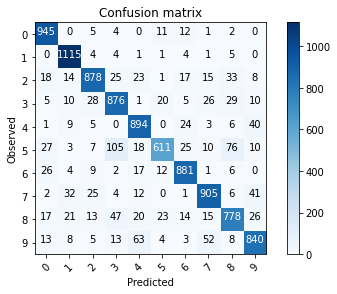

In [91]:
from collections import Counter
from sklearn.metrics import confusion_matrix
import itertools

# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

Report PPV (aka Precision), Sensitivity (aka Recall), Specificity (aka TNR, True Negative Rate) and NPV:

In [99]:
import sklearn.metrics
import math
def matrix_metrics(Y_true, Y_pred_classes, beta, label):

  data = {'actual': Y_true, 'pred': Y_pred_classes}
  df1 = pd.DataFrame(data)


  TP = df1.loc[(df1['actual'] == label) & (df1['pred'] == label)].shape[0]
  TN = df1.loc[(df1['actual'] != label) & (df1['pred'] != label)].shape[0]
  FP = df1.loc[(df1['actual'] != label) & (df1['pred'] == label)].shape[0]
  FN = df1.loc[(df1['actual'] == label) & (df1['pred'] != label)].shape[0]

  Population = TN+FN+TP+FP
  Prevalence = round( (TP+FP) / Population,2)
  Accuracy   = round( (TP+TN) / Population,4)
  Precision  = round( TP / (TP+FP),4 )
  NPV        = round( TN / (TN+FN),4 )
  FDR        = round( FP / (TP+FP),4 )
  FOR        = round( FN / (TN+FN),4 ) 
  check_Pos  = Precision + FDR
  check_Neg  = NPV + FOR
  Recall     = round( TP / (TP+FN),4 )
  FPR        = round( FP / (TN+FP),4 )
  FNR        = round( FN / (TP+FN),4 )
  TNR        = round( TN / (TN+FP),4 ) 
  check_Pos2 = Recall + FNR
  check_Neg2 = FPR + TNR
  LRPos      = round( Recall/FPR,4 ) 
  LRNeg      = round( FNR / TNR ,4 )
  DOR        = round( LRPos/LRNeg)
  F1         = round ( 2 * ((Precision*Recall)/(Precision+Recall)),4)
  FBeta      = round ( (1+beta**2)*((Precision*Recall)/((beta**2 * Precision)+ Recall)) ,4)
  MCC        = round ( ((TP*TN)-(FP*FN))/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))  ,4)
  BM         = Recall+TNR-1
  MK         = Precision+NPV-1
  mat_met = pd.DataFrame({
  'Metric':['TP','TN','FP','FN','Prevalence','Accuracy','Precision/PPV','NPV','FDR','FOR','check_Pos','check_Neg','Recall/Sensitivity','FPR','FNR','TNR/Specificty','check_Pos2','check_Neg2','LR+','LR-','DOR','F1','FBeta','MCC','BM','MK'],     'Value':[TP,TN,FP,FN,Prevalence,Accuracy,Precision,NPV,FDR,FOR,check_Pos,check_Neg,Recall,FPR,FNR,TNR,check_Pos2,check_Neg2,LRPos,LRNeg,DOR,F1,FBeta,MCC,BM,MK]})
  return (mat_met)

In [110]:
beta = 0.4
label = 0
mat_met = matrix_metrics(Y_true, Y_pred_classes, beta, label)
mat_met

,Metric,Value
0,TP,945.0000
1,TN,8911.0000
2,FP,109.0000
3,FN,35.0000
4,Prevalence,0.1100
5,Accuracy,0.9856
6,Precision/PPV,0.8966
7,NPV,0.9961
8,FDR,0.1034
9,FOR,0.0039


In [111]:
mat_met[mat_met['Metric'].isin(['Precision/PPV', 'Recall/Sensitivity', 'TNR/Specificty', 'NPV', 'F1'])]

,Metric,Value
6,Precision/PPV,0.8966
7,NPV,0.9961
12,Recall/Sensitivity,0.9643
15,TNR/Specificty,0.9879
21,F1,0.9292
